In [1]:
from sklearn.experimental import enable_iterative_imputer

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from collections import Counter
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin

# Imbalance
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Models

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, Lasso, RidgeClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

# Metrics
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import cross_validate, RandomizedSearchCV

In [3]:
X = pd.read_csv("./train_x.csv")
y = pd.read_csv("./train_y.csv")
data = pd.merge(X, y, on="ID")
# Remove all rows without label
data = data[data["Label"].notna()]
# drop id column as it's not needed anymore
data = data.drop("ID", axis=1)
data["Loan type"] = data["Loan type"].map({ "A": 0, "B": 1 })
data["Occupation type"] = data["Occupation type"].map({ "X": 0, "Y": 1, "Z": 2 })
data.head()

,Expense,Income,Loan type,Occupation type,Age,Score1,Score2,Score3,Score4,Score5,Label
0,1830.943788,14767.28013,1.0,1.0,1.0,0.016885,205.196182,22.521523,600.911200,3464.613291,0.0
1,1645.302546,15272.26775,1.0,1.0,0.0,0.240375,194.266317,5.349117,600.888816,3374.921455,0.0
2,1555.026392,17482.49734,0.0,1.0,0.0,0.213921,183.529871,-1.054954,598.596944,3331.304886,0.0
3,NaN,16257.66493,0.0,1.0,0.0,0.303909,191.228965,6.971750,602.447203,3392.275849,0.0
4,1777.648916,16316.29914,1.0,0.0,1.0,NaN,224.074728,11.218489,605.947340,3438.864083,0.0


### Check for highly correlated columns

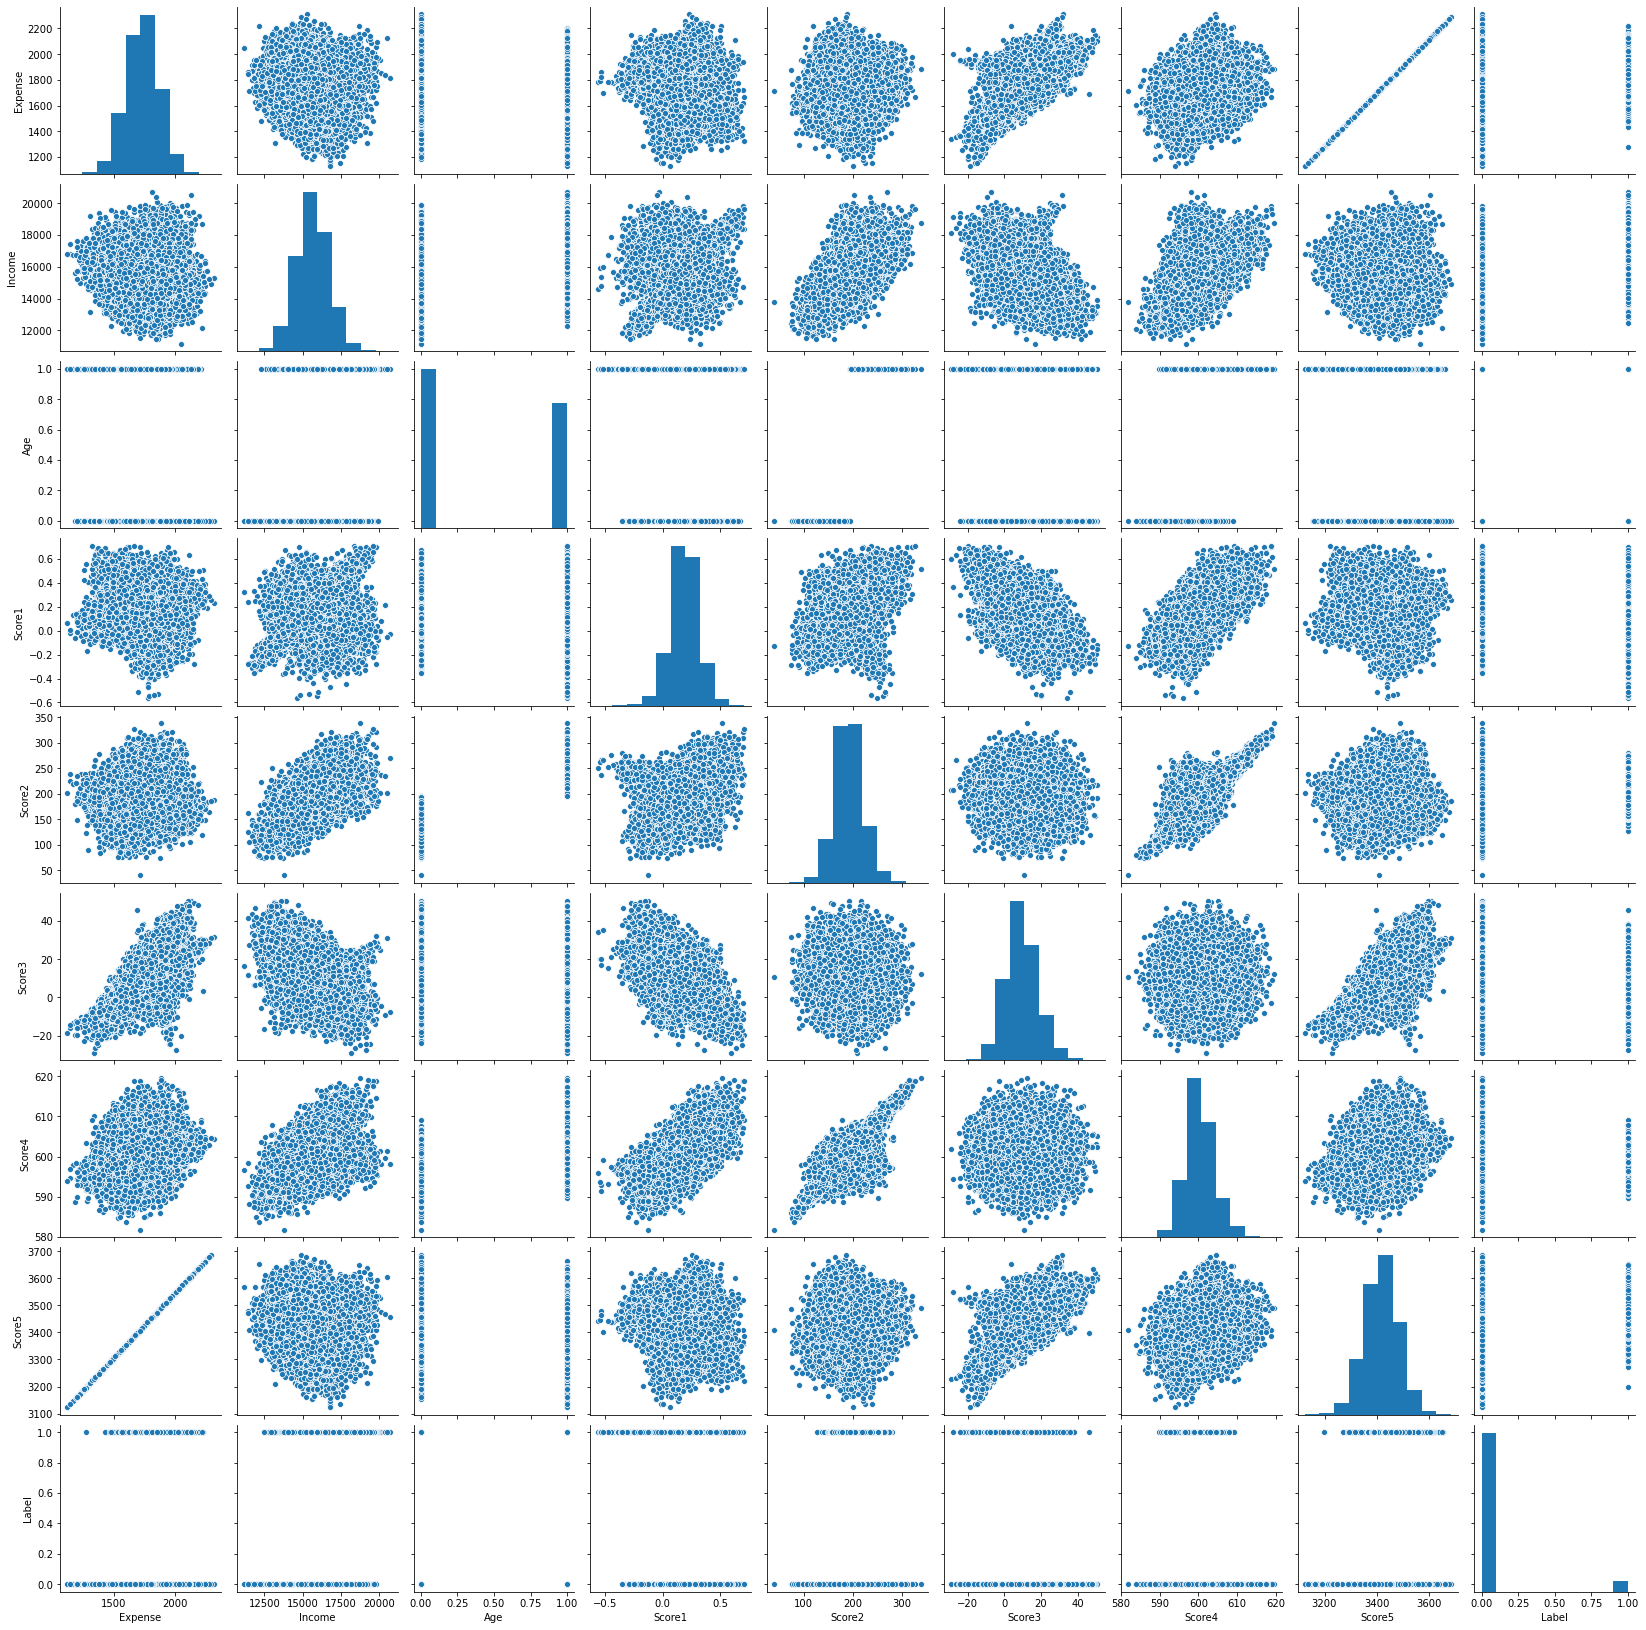

In [99]:
sns.pairplot(data)

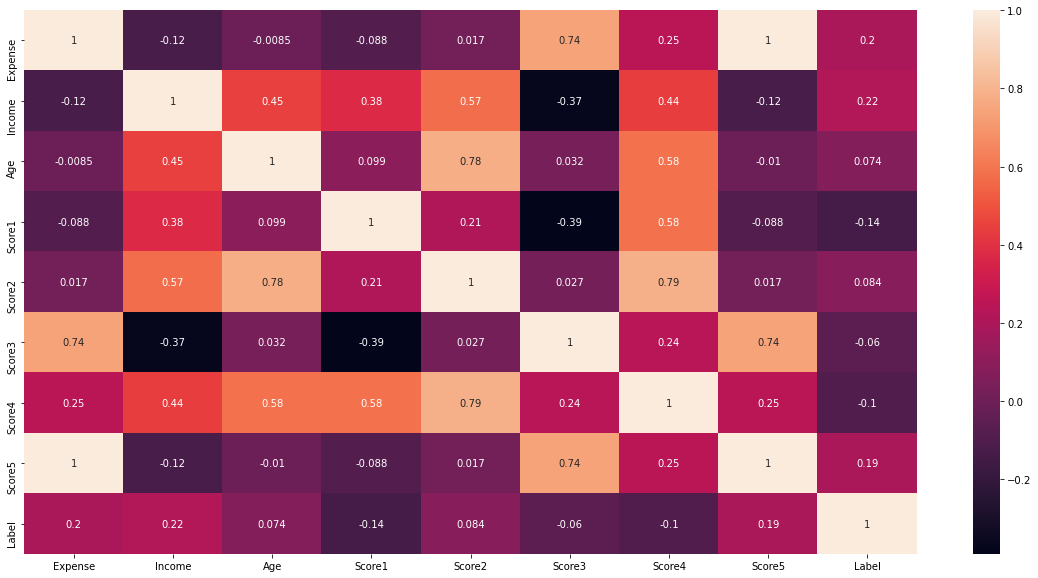

In [105]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(data.corr(), annot=True, ax=ax)

In [4]:
# Drop highly correlated features
corr = data.corr()
tol = 0.95
upper_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > tol)]
data = data.drop(to_drop, axis=1)
to_drop

['Score5']

### Filling missing values and scaling using pipelines

In [5]:
data.isna().sum()

Expense            1949
Income             1867
Loan type          1923
Occupation type    1781
Age                1909
Score1             1839
Score2             1941
Score3             1854
Score4             1874
Label                 0
dtype: int64

In [59]:
class KNNImputerCustom(BaseEstimator, TransformerMixin):
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.imputer = KNNImputer(n_neighbors=self.n_neighbors)
    
    def fit(self, X):
        return self.imputer.fit(X)
    
    def transform(self, X):
        return np.round(self.imputer.transform(X))
    
    def fit_transform(self, X, y):
        return np.round(self.imputer.fit_transform(X))

In [52]:
# Replacing nan values with mean since it follows a normal distribution as shown in above graphs
numerical_columns = ['Expense', 'Income', 'Score1', 'Score2', 'Score3', 'Score4']
numeric_transformer = Pipeline(
                        steps=[
                            ('imputer', IterativeImputer(max_iter=10, random_state=0)),
                            ('scaler', MinMaxScaler())
                        ]
                    )

# Replacing nan values with mode for categorical data
categorical_columns = ['Loan type', 'Occupation type', 'Age']
categorical_transformer = Pipeline(
                                    steps=[
                                        ('imputer', KNNImputerCustom(n_neighbors=5)),
                                        ('onehot', OneHotEncoder(drop='first'))
                                    ]
                                  )
# Column transformer
column_transformer = ColumnTransformer(
                    transformers=[
                        ('numerical', numeric_transformer, numerical_columns),
                        ('categorical', categorical_transformer, categorical_columns)
                    ]
            )

# Total preprocessor pipeline
preprocessor = Pipeline(
                    steps=[
                        ('columns', column_transformer),
                    ]
                )

### Split dataset

In [53]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

### Handle data imbalance

In [7]:
np.sum(y_train == 0) / len(y_train)

0.9343911815471521

It can be seen from above that 93% of the training dataset is having label 0 which will lead to unintentional bias towards label 0. In order to avoid that oversampling with SMOTE is used as shown below.

In [54]:
# oversampler = SMOTE()
oversampler = RandomOverSampler()
X_train, y_train = oversampler.fit_resample(X_train, y_train)

### Train the model

In [34]:
def evaluate_classifier(classifier):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(
        f"The accuracy is {classifier.score(X_test, y_test)} \
        \nThe f1_score is {f1_score(y_test, y_pred)} \
        \n\n The confusion matrix is \n {confusion_matrix(y_test, y_pred)} \n"
    )
    return classifier

In [35]:
xgb = evaluate_classifier(XGBClassifier(n_jobs=-1, random_state=0))

[22:08:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The accuracy is 0.9755584756898817         
The f1_score is 0.8279370952821462         

 The confusion matrix is 
 [[13953   241]
 [  131   895]] 



In [60]:
rf = evaluate_classifier(RandomForestClassifier(random_state=0, n_estimators=250))

The accuracy is 0.9837056504599212         
The f1_score is 0.8733401430030643         

 The confusion matrix is 
 [[14117    77]
 [  171   855]] 



In [37]:
knn = evaluate_classifier(KNeighborsClassifier())

The accuracy is 0.9709592641261499         
The f1_score is 0.8021486123545211         

 The confusion matrix is 
 [[13882   312]
 [  130   896]] 



In [40]:
svc = evaluate_classifier(SVC(gamma='auto', kernel='rbf'))

The accuracy is 0.9176741130091984         
The f1_score is 0.5849619079165286         

 The confusion matrix is 
 [[13084  1110]
 [  143   883]] 



In [36]:
voting = evaluate_classifier(VotingClassifier([("xgb", XGBClassifier( n_jobs=-1, random_state=0)),
                               ("rf", RandomForestClassifier(random_state=0)),
                              ],
                              voting="soft",
                              flatten_transform=True
                             ))

[22:08:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The accuracy is 0.9810775295663601         
The f1_score is 0.8590998043052838         

 The confusion matrix is 
 [[14054   140]
 [  148   878]] 



In [38]:
voting = evaluate_classifier(VotingClassifier([("xgb", XGBClassifier(eval_metric="logloss", n_jobs=-1)),
                               ("svm", SVC(gamma='auto', probability=True)),
                               ("rf", RandomForestClassifier()),
                                ("knn", KNeighborsClassifier(3)),
                              ],
                              voting="soft",
                              flatten_transform=True
                             ))

The accuracy is 0.9800919842312746         
The f1_score is 0.8545367258761402         

 The confusion matrix is 
 [[14027   167]
 [  136   890]] 



In [29]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the grid
grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': [True]}

In [30]:
# Use the random grid to search for best hyperparameters
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = grid, n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:  2.7min remaining:   17.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.7min finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 116, 133, 150,
                                                         166, 183, 200, 216,
                                                         233, 250]},
                   random_state=42, verbose=2)

In [63]:
rf_random.best_params_

{'n_estimators': 366,  'min_samples_split': 5,  'min_samples_leaf': 1,  'max_depth': 60,  'bootstrap': True}


In [64]:
rf_ = RandomForestClassifier(
    n_estimators=366,
    min_samples_split=5,
    min_samples_leaf=1,
    max_depth=60,
    bootstrap=True
)

In [65]:
rf_.fit(X_train, y_train)

RandomForestClassifier(max_depth=60, min_samples_split=5, n_estimators=366)

### Predictions

In [61]:
test = pd.read_csv("./test_x.csv")

# drop id column as it's not needed anymore
test = test.drop("ID_Test", axis=1)
test["Loan type"] = test["Loan type"].map({ "A": 0, "B": 1 })
test["Occupation type"] = test["Occupation type"].map({ "X": 0, "Y": 1, "Z": 2 })

test = test.drop(to_drop, axis=1)
test = preprocessor.transform(test)
pred_tune = rf_random.predict(test)

In [66]:
pred_tune = rf_.predict(test)

In [70]:
test_ = pd.read_csv("./test_x.csv")
predictions = pd.DataFrame({
    "ID": test_["ID_Test"],
    "Label": pred_tune
})

In [75]:
predictions.to_csv("pred_y.csv", index=False)